In [7]:
#@title Install and Setup Dependencies

# Necessary for matplotlib to work in GPU mode
%matplotlib inline

import os, sys, shutil

### Clone First Order Motion
if not os.path.exists('/content/first-order-model'):
  print('Cloning First Order Model...')
  !git clone --quiet https://github.com/AliaksandrSiarohin/first-order-model
  # Adding to path makes for easier imports
  sys.path.insert(1, '/content/first-order-model') 
  print('Done cloning First Order Model.')
else:
  if '/content/first-order-model' not in sys.path:
    sys.path.insert(1, '/content/first-order-model')
  print('First Order Model already exists.')

### Clone DeepGame
if not os.path.exists('/content/Deepgame'):
  print('Cloning Deepgame...')
  !git clone --quiet https://github.com/mertalpt/Deepgame.git
  # Adding to the path makes for easier imports
  sys.path.insert(2, '/content/Deepgame/deepgame-cloud')
  print('Done cloning Deepgame.')
  # Install dependencies
  print('Installing Deepgame\'s dependencies...')
  !pip install --quiet -r '/content/Deepgame/deepgame-cloud/requirements.txt'
  print('Done installing Deepgame\'s dependencies.')
else:
  if '/content/Deepgame/deepgame-cloud' not in sys.path:
    sys.path.insert(2, '/content/Deepgame/deepgame-cloud')
  print('Deepgame already exists.')

### Copy over data
data_path = '/content/data'
if not os.path.exists(data_path):
  print('Copying data from Drive.')
  from kora import drive
  folder_id = '1COKJuItmwH_GoBUTLXQiGq53OVm9PFKa'
  folder_name = drive.download_folder(folder_id)
  shutil.move('./{}'.format(folder_name), data_path)
  print('Done copying data from Drive.')
else:
  print('Drive data already exists.')

First Order Model already exists.
Deepgame already exists.
Drive data already exists.


In [8]:
#@title Initialize Workspace
#@markdown First run may take over 5 minutes.

#@markdown ---

#@markdown Select a model to work with:

### Initialization of ImageAnimater
config_name = 'vox-adv-256' #@param ['vox-256', 'vox-adv-256'] {type: 'string'}
config_path = '{}/config/{}.yaml'.format(data_path, config_name)
# Deduce checkpoint file from the config
if config_name == 'vox-256':
  checkpoint_name = 'vox-cpk'
elif config_name == 'vox-adv-256':
  checkpoint_name = 'vox-adv-cpk'
else:
  raise ValueError('Unrecognized config name was input.')
checkpoint_path = '{}/checkpoints/{}.pth.tar'.format(data_path, checkpoint_name)
# Initialize ImageAnimater
print('Initializing Image Animater.')
from ImageAnimater import ImageAnimater
animater = ImageAnimater(config_path, checkpoint_path)
print('Done initializing Image Animater.')

### Initialization of StyleTransferer
# Cache ML model to avoid 5-10 minutes load time
# at each rerun
print('Initializing Style Transferer.')
from StyleTransferer import StyleTransferer
if '__module' in globals():
  style_transferer = StyleTransferer(__module)
else:
  style_transferer = StyleTransferer()
  __module = style_transferer.hub_module
print('Done initializing Style Transferer.')

Initializing Image Animater.
Done initializing Image Animater.
Initializing Style Transferer.
Done initializing Style Transferer.


Content image will be searched in /content/data/images/got-02.png.
Style image will be searched in /content/data/images/character-01.png.


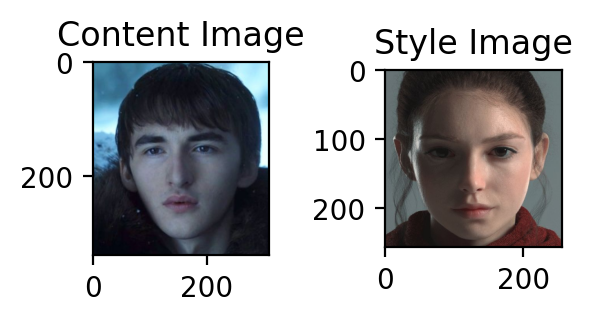

In [9]:
#@title Select Input Images

#@markdown ---
#@markdown ### Select image of the person to work on:
#@markdown You may enter a custom path.
content_image_path = 'got-02.png' #@param ['got-02.png', 'got-03.png', 'got-04.png', 'got-05.png', 'got-06.png', 'got-07.png', 'got-08.png'] {type: 'string', allow-input: true}
#@markdown Whether the input path is inside the common data path.
content_in_data_path = True #@param {type: 'boolean'}
content_path = '{}/images/{}'.format(data_path, content_image_path) if content_in_data_path else content_image_path
print('Content image will be searched in {}.'.format(content_path))

#@markdown ---
#@markdown ### Select a style image to use:
#@markdown You may enter a custom path.
style_image_path = 'character-01.png' #@param ['character-01.png', 'character-02.png'] {type: 'string', allow-input: true}
#@markdown Whether the input path is inside the common data path.
style_in_data_path = True #@param {type: 'boolean'}
style_path = '{}/images/{}'.format(data_path, style_image_path) if style_in_data_path else style_image_path
print('Style image will be searched in {}.'.format(style_path))

# Load images
from DGImage import DGImage
content_image = DGImage.from_path(content_path)
style_image = DGImage.from_path(style_path)

#@markdown ---
#@markdown ### Input Images Displayed:
DGImage.display(content_image, style_image, titles=['Content Image', 'Style Image'])

In [10]:
#@title Select Input Video

#@markdown ---
#@markdown ### Select a driver video to animate images with:
#@markdown You may enter a custom path.
video_path = '00.mp4' #@param ['00.mp4', '04.mp4', '08.mp4', '10-backward.mp4', '10.mp4'] {type: 'string', allow-input: true}
#@markdown Whether the input path is inside the common data path.
video_in_data_path = True #@param {type: 'boolean'}
driver_video_path = '{}/videos/{}'.format(data_path, video_path) if video_in_data_path else video_path
print('The video will be searched in {}.'.format(driver_video_path))

# Load video
from DGVideo import DGVideo
driver_video = DGVideo.from_path(driver_video_path)

#@markdown ---
#@markdown ### Input Video Displayed:
from IPython.display import HTML
driver_anim = driver_video.animation(title='Driver Video')
HTML(driver_anim.to_html5_video())

The video will be searched in /content/data/videos/00.mp4.


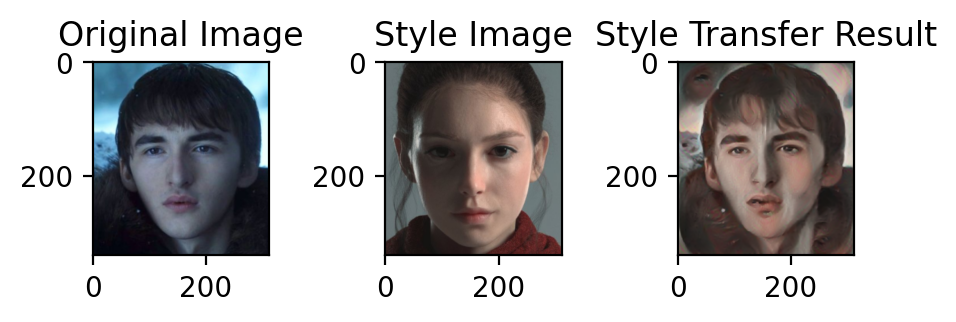

In [12]:
#@title Apply Style Transfer

styled_image = style_transferer.stylize(style_image, content_image)

# Resize the original to match the styled one
styled_shape = styled_image.shape()
content_image = content_image.resize(styled_shape[:2])
style_image = style_image.resize(styled_shape[:2])

#@markdown ---
#@markdown ### Result:
from DGImage import DGImage
DGImage.display(content_image, style_image, styled_image, 
                titles=['Original Image', 'Style Image', 'Style Transfer Result'])

### Construct a Mask for the Image

Unfortunately, this step requires human intervention. You are supposed to construct a mask that covers the background of an image. We will construct the mask on the original image, then apply the mask to the result of the style transfer. Constructing the mask directly on the result may work better in some cases.

Mask pieces can be constructed automatically or manually by inputting pixels on an image and marking whether to keep them. Refer to the *MaskOperations* class source code for better understanding.

We will feature the automatic construction here. 

Afterwards, you are supposed to use set operations *union, difference and intersection* included in the *MaskOperations* class to construct a mask.

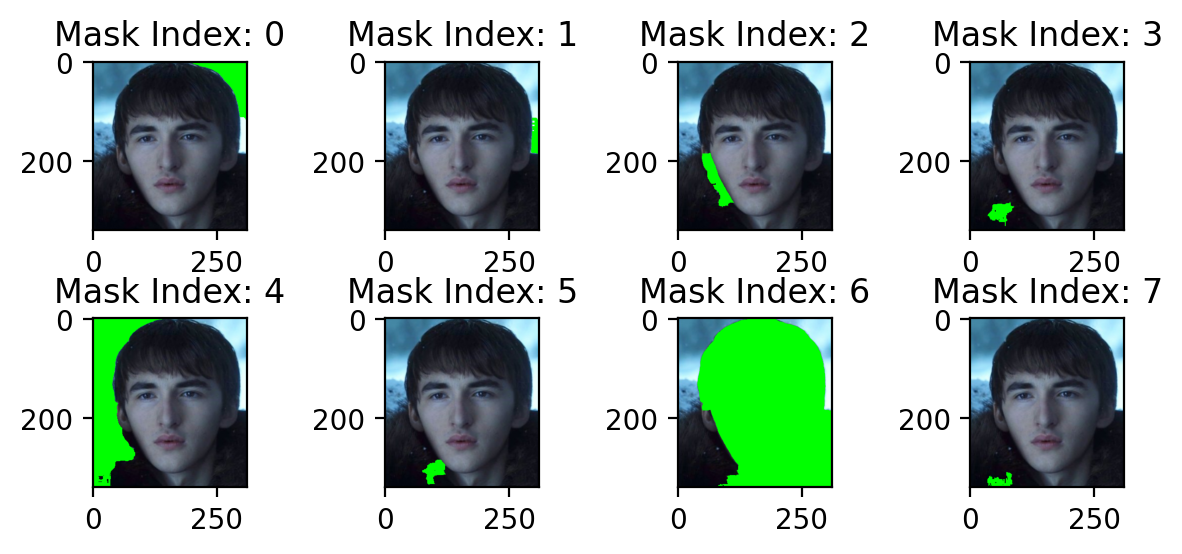

In [20]:
#@markdown ### Automatically Generated Mask Pieces

#@markdown ---

#@markdown How bright of pixels count for a segment of their own?
brightness_threshold = 0.98 #@param {type: 'slider', min: 0.0, max: 1.0, step: 0.01}

#@markdown ---

#@markdown How dark of pixels count for a segment of their own?
darkness_threshold = 0.02  #@param {type: 'slider', min: 0.0, max: 1.0, step: 0.01}

#@markdown ---

#@markdown How hard to blur edges when detecting contours?
sigma = 2.0 #@param {type: 'slider', min: 0.1, max: 5.0, step: 0.1}

#@markdown ---

#@markdown For which pixel count the segments should be filtered out?
size_filter = 200 #@param {type: 'integer'}

from MaskOperations import MaskOperations
masks = MaskOperations.generate(content_image,
                                light_mod=brightness_threshold,
                                dark_mod=darkness_threshold,
                                sigma=sigma,
                                size_lim=size_filter)

#@markdown ---
#@markdown ### Generated Pieces:
MaskOperations.display(content_image, masks)

Here, we apply set operations to construct the final mask. 

Do not run blindly, may not work for your inputs without changes.

Some notes about possible operations:

*    Union: Joins masks. Use 'MaskOperations.union(*masks)'.
*    Intersection: Takes common points of masks. Use 'MaskOperations.intersection(*masks)'.
*    Difference: Removes common points of two masks from the first one. Use 'MaskOperations.difference(mask_1, mask_2)'.
*    Negation: Flips the mask. Use '~mask', it is an operator that results in a flipped mask.

If you are patient, you can accumulate masks from different runs of the previous cell. That way you can fine tune your mask.

In [22]:
from MaskOperations import MaskOperations

final_mask = ~masks[6]

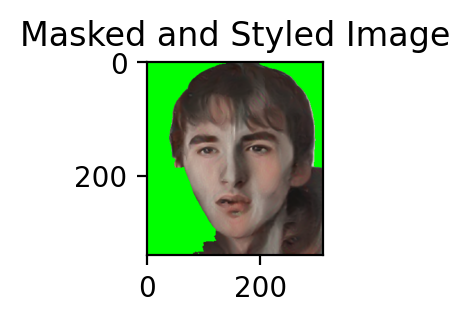

In [24]:
#@title Resulting Mask Applied
#@markdown Final mask is expected in a variable named 'final_mask'.

masked_image = MaskOperations.apply(styled_image, final_mask)

#@markdown ---

#@markdown ### Displayed:
from DGImage import DGImage
DGImage.display(masked_image, titles=['Masked and Styled Image'])

In [ ]:
#@title Animate the Result

print('Animating...')
animated = animater.animate(driver=driver_video, target=masked_image)
print('Done.')

In [29]:
#@title Display the Result
#@markdown ---
from IPython.display import HTML
animation = animated.animation()
HTML(animation.to_html5_video())

In [30]:
#@title Save the Result

#@markdown ---

#@markdown Which format to save the files as?
output_format = '.mp4 File' #@param ['.mp4 File', 'Into a Directory with Frames Separated as PNG Images']

#@markdown ---

#@markdown Root directory to save the result in:
output_path = '/content/' #@param {type: 'string'}

#@markdown ---

#@markdown If format is mp4, will be the file name.

#@markdown If format is frames as PNGs, will be file name prefix.
file_name = 'result' #@param {type: 'string'}

print('Saving...')
import os
if output_format == '.mp4 File':
  result_path = '{}/{}.mp4'.format(output_path, file_name)
  if os.path.isdir(result_path):
    raise ValueError('Save path already exists as a directory.')
  animated.save(result_path)
else:
  if not os.path.exists(output_path):
    os.mkdir(output_path)
  elif os.path.isfile(output_path):
    raiseValueError('Save path already exists as a file.')
  animated.save_to_directory(output_path, prefix=file_name)

print('Done saving.')

Saving...
Done saving.
